In [67]:
import matplotlib.pyplot as plt
import mne
import os
import os.path as osp

import pandas as pd
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyriemann.spatialfilters import Xdawn
import numpy as np
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import XdawnCovariances
from pyriemann.estimation import Covariances

import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

from numpy.random import seed

import winsound
import time



In [10]:
mne.set_log_level(verbose="Warning") # set all the mne verbose to warning
seed(2002012)

In [11]:
init_path = "C:\\Users\dtrocell\Documents\ML\Big dataset\signal"
files_dir=os.listdir(init_path)[1:4]
participant_dir= [os.listdir(osp.join(init_path,files_dir[i])) for i in range(len(files_dir))]
print("you have succesfuly acces to the directory : ",init_path)

you have succesfuly acces to the directory :  C:\Users\dtrocell\Documents\ML\Big dataset\signal


In [12]:
participant_dir[0].remove("A40") # Dont have 40 events

In [13]:
def collect_data(files_dir, participant_dir):
    dic_data_train ={}
    dic_data_test ={}
    for i in range(len(files_dir)):
        for j in range(len(participant_dir[i])):
            #Train dataset
            dic_data_train[participant_dir[i][j]+"_1"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R1_acquisition.gdf"), verbose="CRITICAL")
            dic_data_train[participant_dir[i][j]+"_2"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R2_acquisition.gdf"), verbose="CRITICAL")

            #Test dataset
            dic_data_test[participant_dir[i][j]+"_3"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R3_onlineT.gdf"), verbose="CRITICAL")
            dic_data_test[participant_dir[i][j]+"_4"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R4_onlineT.gdf"), verbose="CRITICAL")
            try : # allow to manage the one where there is no _5 and _6 files
                dic_data_test[participant_dir[i][j]+"_5"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R5_onlineT.gdf"), verbose="CRITICAL")
            except FileNotFoundError:
                pass

            try :
                dic_data_test[participant_dir[i][j]+"_6"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R6_onlineT.gdf"), verbose="CRITICAL")
            except FileNotFoundError:
                pass
    return dic_data_train, dic_data_test


In [14]:
print("START extraction data")
dic_data_train,dic_data_test=  collect_data(files_dir, participant_dir)
print("extraction data DONE")


START extraction data
extraction data DONE


In [15]:
participant_dir =  [participant for session in participant_dir for participant in session] # flatten the list of the 3 participant session list in one big list

Stimulation code
left =769
right = 770
end of trial =800

In [16]:
def preprocess(raw, steps = {}):
    """ preprocess the data"""
    assert isinstance(steps, dict), "les steps doivent être un dictionnaire d'étapes"
    raw.load_data()
    if "drop_channels" in steps.keys():
        #remove the wanted channels
        for channel in steps["drop_channels"] : #Pour chaque channel  a supprimer
            if channel in raw.ch_names: raw.drop_channels(channel) # Vérifie qu'il est present et le supprime

    if "filter" in steps.keys():
        assert isinstance(steps["filter"], list), "les paramètres de 'filter' doivent une liste suivant cette forme [l_freq,h_freq]"
        raw.filter(steps["filter"][0], steps["filter"][1])


    return raw

In [17]:
#steps_preprocess = {"filter" : [1,32]}
#_ =  preprocess(dic_data_train["A2_1"],steps_preprocess)

In [18]:
# _= preprocess(dic_data_train["A1_1"],steps_preprocess)
# _=dic_data_train["A1_1"].plot(duration=5
#                             )

In [19]:
steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd',] ,
                    "tmin" : 0.5 , "tmax" : 4, "overlap" :1/16, "lenght": 1,
                    "score" : "EAcc"}
_= preprocess(dic_data_train["A1_1"],steps_preprocess)
# _=dic_data_train["A1_1"].plot(duration=5)

In [20]:
def epoching(dict, key_session =[], steps_preprocess = None , key_events={"770":0 ,"800":1}) :
    """From the dictionary of mne.rawGDF extract all the epochs selected with Key_session
     Return the epochs list as X and tje label as Y"""

    #---------------------------------------------
    tmin= steps_preprocess["tmin"]
    tmax = steps_preprocess["tmax"]
    length_epoch = steps_preprocess["lenght"]
    overlap = steps_preprocess["overlap"]
    shift = steps_preprocess["shift"] * dict[key_session[0]].info['sfreq']

    list_start = np.arange(tmin, (tmax +overlap)- length_epoch, overlap)
    list_stop = np.arange(tmin+length_epoch, (tmax+overlap), overlap)
    n_chans = 27  # must be changed if we drop more channels

    time_step = int(length_epoch  * dict[key_session[0]].info['sfreq'])
    n_events = len(list_start)* 40 * len(key_session) # 40 represent the number of events in each raw data

#---------------------------------------------
    X= np.zeros((n_events, n_chans, time_step))
    Y= np.zeros((n_events))

    #------------ Initial clasifier ------------
    #
    # for key in key_session :
    #
    #
    #     if steps_preprocess is not None :
    #         _ =  preprocess(dict[key],steps_preprocess)
    #
    #     events = mne.events_from_annotations(dict[key],key_events)[0]
    #
    #     events_rest=  np.array([events[:,0] + shift , events[:,1], np.zeros(events.shape[0])+1],dtype="int64" ).T
    #
    #     events =  np.append(events, events_rest, axis=0)
    #
    #     epoch= mne.Epochs(dict[key], events, tmin= -1 , tmax= 5 , baseline=(None, 0),  verbose="CRITICAL")
    #
    #
    #     for start, stop in zip(list_start, list_stop):
    #         if X is None :
    #             X = epoch.get_data(tmin=start , tmax=stop)
    #             Y = epoch.events[:,2]
    #
    #         else :
    #             X = np.append(X,epoch.get_data(tmin=start , tmax=stop), axis= 0)
    #             Y = np.append(Y,epoch.events[:,2], axis=0)
    #
    # return X,Y


    #------------ Initial clasifier ------------


    j = 0

    #for key in tqdm(key_session , desc="epoching"):
    for key in key_session :


        if steps_preprocess is not None :
            _ =  preprocess(dict[key],steps_preprocess)

        events = mne.events_from_annotations(dict[key],key_events)[0]

    # #-------------- Initlial event selectionner  -------------------
    # """ Take all the events in dictionnary, Active (left or right) and all rest.
    #  Identify of key 0 that correspond to active ( Left or right).
    #  Select the rest face at the end of the trial active.
    #  Allow to manage the inbalance the sample biais between rest and active, due to the fact that the active trials can left, right or both.
    # """
    #
    #     new_events = []
    #
    #     for i in range(len(events)) :
    #         if events[i][2] == 0:
    #             new_events.append(events[i])
    #             new_events.append(events[i+1])
    #     new_events =np.array(new_events)
    #     all_events = new_events
    # #---------------------------------------------------

    #-------------- New event selectionner -------------------

        events_rest=  np.array([events[:,0] + shift , events[:,1], np.zeros(events.shape[0])+1],dtype="int64" ).T
        all_events =  np.append(events, events_rest, axis=0)
    #--------------------------------------------------------

        all_events = all_events[all_events[:, 0].argsort()]
        # all_events.sort(axis=0) # Trie les evenements dans l'ordre, nécéssaire pour l'optimisation de MNE

        epoch= mne.Epochs(dict[key], all_events, tmin= -1 , tmax= 5 , baseline=(-1, 5))

        assert len(epoch.events[:,2]) == 40, ( "'%s' don't have 40 events it actually have %s " % (key , len(epoch.events[:,2])) )

        for start, stop in zip(list_start, list_stop):
            X[j : j +40 ] = epoch.get_data(tmin=start , tmax=stop)
            Y[j : j +40 ] = epoch.events[:,2]
            j += 40

    return X,Y

# X,Y = epoching(dic_data_train, ["A3_1","A1_2"], steps_preprocess, key_events={"769":0,  "800" : 1})
#
#

In [21]:
#steps_preprocess = {"filter" : [1,32]}
#key_events =  {"769":0 ,"770":1}
#X,Y = epoching(dic_data_train, ["A3_1","A1_2"], steps_preprocess)

# within session classification

In [22]:
#subject = "A1"
#train_key = [subject+"_1", subject+"_2"]
#test_key = [subject+"_3", subject+"_4",subject+"_5", subject+"_6"]

#X_train, Y_train = epoching(dic_data_train,train_key,steps_preprocess)
#X_test, Y_test = epoching(dic_data_test,test_key,steps_preprocess)


In [23]:



pipelines = {}

# pipelines['8 csp+lda'] = make_pipeline(CSP(n_components=8), LDA())
pipelines['6 csp+lda'] = make_pipeline(CSP(n_components=6), LDA())
# # pipelines['xdawn+svm'] = make_pipeline(Xdawn(nfilter=2), LDA())
# pipelines['tgsp+svm'] = make_pipeline(Covariances(estimator='lwf'),
#                                       TangentSpace(metric='riemann'),
#                                       SVC(kernel='linear'))
# pipelines['MDM'] = make_p

# pipelines['XDAWN+tgsp+svm'] = make_pipeline(XdawnCovariances(estimator='lwf'),
#                                       TangentSpace(metric='riemann'),
#                                       SVC(kernel='linear'))
# pipelines['XDAWN+MDM'] = make_pipeline(XdawnCovariances(estimator='lwf'),
#                                  MDM(metric='riemann', n_jobs=-1))

#pipelines['FBSCP+ lda'] =make_pipeline(fbcsp(), LDA())


In [24]:
def test_pipeline_within_session(pipelines, session, steps_preprocess = None, key_events={"770":0, "769":0} ) :
    """ Take in input the different pipelines to test and return the corresponding classification accuracy"""

    accuracy =pd.DataFrame(np.zeros((len(session),len(pipelines))), index= session ,columns= pipelines.keys())

    for subject in tqdm(session, desc="subject"):

        train_key = [subject+"_1", subject+"_2"]
        if subject == "A59" : #Manage the error during the data acquisition
            test_key = [subject+"_3", subject+"_4"]
        else : #Take all the session possible
            test_key = [subject+"_3", subject+"_4", subject+"_5", subject+"_6"]

        X_train, Y_train = epoching(dic_data_train,train_key, steps_preprocess, key_events)
        X_test, Y_test = epoching(dic_data_test,test_key, steps_preprocess, key_events)

        for classifier in pipelines.keys() :
                pipelines[classifier].fit(X_train,Y_train)

                # if steps_preprocess["score"] ==  "TAcc_false":
                #
                #     #---------------------------------------------
                #     tmin= steps_preprocess["tmin"]
                #     tmax = steps_preprocess["tmax"]
                #     length_epoch = steps_preprocess["lenght"]
                #     overlap = steps_preprocess["overlap"]
                #     #---------------------------------------------
                #     dist = len(np.arange(tmin, (tmax +overlap)- length_epoch, overlap))
                #     X_predict =pipelines[classifier].predict(X_test)
                #     X_estim =  pipelines[classifier].transform(X_test)
                #     temporary_accuracy = np.zeros((1,dist+1))
                #
                #     for i in range(dist):
                #         temporary_accuracy[0, i] = accuracy_score(X_predict[i :: dist-1], Y_test [i :: dist-1])
                #         # mesure the accuracy of each trial
                #         print("x predict : ", X_predict[i :: dist])
                #         print("X_estim : " , X_estim[i :: dist])
                #
                #     print(temporary_accuracy)
                #
                #     # its binary 0 if in mean the trial was badly identified 1 instead
                #     temporary_accuracy = np.around(temporary_accuracy)
                #     print(temporary_accuracy)
                #     accuracy[classifier] [subject]= temporary_accuracy.mean()

                if steps_preprocess["score"] ==  "TAcc":


                    #X_predict =pipelines[classifier].predict(X_test)
                    X_estim =  pipelines[classifier].transform(X_test)

                    X_estim_reshape =X_estim.reshape((len(test_key),-1,40)) # je transforme reshape les estimation en tableau de la forme (session, epochs,trial)
                    Y_test_reshape =Y_test.reshape((len(test_key),-1,40))
                    X_sum = X_estim_reshape.sum(axis=1) #je fais la somme de tout les epochs

                    #solutione le probleme que la projection de la LDA n'est pas toujours négatif pour gauche et positif pour droite
                    if pipelines[classifier].predict(X_test[0:1,:,:])[0] == 1 and pipelines[classifier].transform(X_test[0:1,:,:])[0][0] > 0 or pipelines[classifier].predict(X_test[0:1,:,:])[0] == 0 and pipelines[classifier].transform(X_test[0:1,:,:])[0][0] < 0:
                        trial_predict = np.where(X_sum < 0, 0, 1) # si la sommme des predictions est négative alors le trial est prédit gauche (0) sinon il est prédit droit (1)
                    else :
                        trial_predict = np.where(X_sum < 0, 1, 0) # si la sommme des predictions est négative alors le trial est prédit gauche (0) sinon il est prédit droit (1)


                    temporary_accuracy = np.where(trial_predict== Y_test_reshape[:,0,:], 1,0) #Compare les prédictions avec les observations

                    accuracy[classifier] [subject]= temporary_accuracy.mean()

                elif steps_preprocess["score"] ==  "EAcc":
                    try:
                        accuracy[classifier] [subject]=  pipelines[classifier].score(X_test,Y_test)
                    except :
                        accuracy[classifier] [subject]= np.nan
                else :
                    raise AttributeError("le type de score choisi n'existe pas. Vérifie l'ortographe ! ")
    winsound.Beep(440, 500)
    winsound.Beep(330, 400)
    winsound.Beep(550, 500)
    return accuracy

#participant_dir[0].remove('A59')
session = participant_dir #get the list of participant in the first exeperiment
steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.5 , "tmax" : 3.5, "overlap" :1, "lenght": 3,
                    "shift" : -3,
                    "score" : "EAcc"}
# accuracy = test_pipeline_within_session(pipelines, session, steps_preprocess, key_events={"770":0})

In [25]:
accuracy  = pd.DataFrame(index=session, columns= np.arange(- 5.5, -2.3, 0.5))
for shift in np.arange(- 5.5, -2.3, 0.5):

    steps_preprocess = {"filter" : [8,30],
                        "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                        "tmin" : 0.5 , "tmax" : 3.5, "overlap" :1, "lenght": 3.5,
                        "shift" : shift,
                        "score" : "TAcc"}
    accuracy[shift] = test_pipeline_within_session(pipelines, session, steps_preprocess,  key_events={"770":0})


subject:   1%|          | 1/86 [00:03<04:37,  3.26s/it]


KeyboardInterrupt: 

In [44]:
accuracy.mean(axis=0)

-5.5    0.717151
-5.0    0.719331
-4.5    0.702180
-4.0    0.690116
-3.5    0.677326
-3.0    0.646875
-2.5    0.633285
dtype: float64

In [45]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(accuracy[-5.5],accuracy[-5.0],accuracy[-4.5],accuracy[-4.0],accuracy[-3.5],accuracy[-3.0], accuracy[-2.5], axis=0)
print(fvalue, pvalue)

5.119101696400815 3.848688315523333e-05


In [46]:
accuracy_right = accuracy.copy()

In [47]:
accuracy_right.to_csv("results/shift_rest_vs_MI_right_full_baseline.csv")

In [77]:
accuracy_left.to_csv("shift_rest_vs_MI_left.csv")

Retour Fabien :
IIR filtre  ordre 4
FIR ordre 50

"tmin" : 0.5 , "tmax" : 2.6, "overlap" :2, "lenght": 2}

# Visualisation des résultats

In [26]:
accuracy.mean(axis=0)

-5.5   NaN
-5.0   NaN
-4.5   NaN
-4.0   NaN
-3.5   NaN
-3.0   NaN
-2.5   NaN
dtype: float64

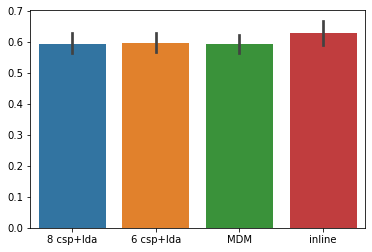

In [86]:
ax = sns.barplot(data= accuracy)

# Comparing to inline data

Text(0.5, 1.0, 'Comparaison des performances entre deux models')

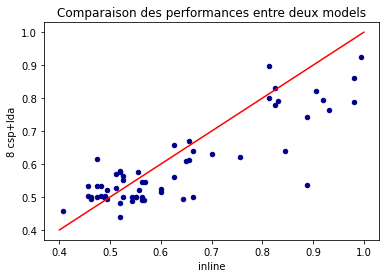

In [83]:
inline_accuracy = [84.375,55.625,98.125,51.25,51.25,65.625,47.5,56.225,66.25,82.5,51.875,60,65,49.375,75.625,49.375,45.625,82.5,98.125,83.125,56.875,88.75,51.875,93.125,81.25,65.625,45.625,48.125,52.5, 40.625, 52.5, 55.5, 62.5, 48.125, 90.625, 70, 47.5, 62.5, 81.25, 49.0625, 51.875, 51.875, 55, 56.25, 54.375, 54.375, 46.25, 56.625, 55, 52.5, 64.375, 88.75, 46.25, 47.5, 91.875, 99.375, 48.75, 66.25, 60, 56.25, 84.375, 90.625, 60, 50, 82.5, 58.75, 51.875, 55, 60.625, 55.625, 47.5, 44.375, 86.25, 68.125, 71.875, 80.625, 53.75, 55, 97.5, 49.375, 55, 49.375, 44.375, 76.25, 80.625, 62.5 ,73.125]

inline_order = ["A1"  ,"A2" ,"A3" ,"A4" ,"A5" ,"A6" ,"A7" ,"A8" ,"A9" ,"A10" ,"A11" ,"A12" ,"A13" ,"A14" ,"A15" ,"A16" ,"A17" ,"A18" ,"A19" ,"A20" ,"A21" ,"A22" ,"A23" ,"A24" ,"A25" ,"A26" ,"A27" ,"A28" ,"A29" ,"A30" ,"A31" ,"A32" ,"A33" ,"A34" ,"A35" ,"A36" ,"A37" ,"A38" ,"A39" ,"A40" ,"A41" ,"A42" ,"A43" ,"A44" ,"A45" ,"A46" ,"A47" ,"A48" ,"A49" ,"A50" ,"A51" ,"A52" ,"A53" ,"A54" ,"A55" ,"A56" ,"A57" ,"A58" ,"A59" ,"A60" ,"B61" ,"B62" ,"B63" ,"B64" ,"B65" ,"B66" ,"B67" ,"B68" ,"B69" ,"B70" ,"B71" ,"B72" ,"B73" ,"B74" ,"B75" ,"B76" ,"B77" ,"B78" ,"B79" ,"B80" ,"B81" ,"C82" ,"C83" ,"C84" ,"C85" ,"C86" ,"C87"]




inline_results = pd.DataFrame(inline_accuracy, inline_order, columns= ["inline"])
inline_results = inline_results/100

accuracy["inline"] = inline_results["inline"][accuracy.index]

ax1 = accuracy.plot.scatter(x='inline',y='8 csp+lda', c='DarkBlue')
ax1.plot([0.4,1],[0.4,1], c="red")
ax1.set_title("Comparaison des performances entre deux models")

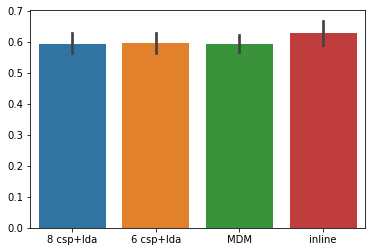

In [74]:
ax = sns.barplot(data= accuracy)

# Removing bad participants

Bad participants are defined by Pauline. It can be because of one specific channel is bad or others problem.

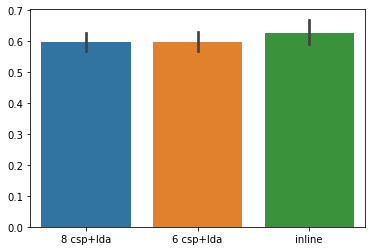

In [52]:
bad_subjects = ["A3","A4","A5","A9","A11","A17","A27","A28","A29","A30","A31","A32","A37","A38","A41","A43","A46","A47","A49","A53","A60"]#,"B64","B67","B68","B69","B70","B78","B79","B81","C82","C83","C86"]

cleaned_accuracy =accuracy.drop(bad_subjects)
ax = sns.barplot(data= accuracy)

In [53]:
cleaned_accuracy.mean()

8 csp+lda    0.627548
6 csp+lda    0.627115
inline       0.675010
dtype: float64

# Bug et issues identifier dans le code
## Steps epoching

List start stop permet de gerer l'epoching avec overlap. Pour cela on utiliser la fonction np.arrange qui permet à partir d'un temps de début et de fin une liste de temps a prendre en compte.
ATTENTION a que la derniere valeur de list_stop soit <= 5 elle est determiné par tmax+overlap
Tu peux vérifier le comportement avec la cellule ci dessous

In [74]:

tmin= 0.5
tmax = 5
length_epoch = 1
overlap = 1/16


list_start = np.arange(tmin, (tmax +overlap)- length_epoch, overlap)
list_stop = np.arange(tmin+length_epoch, (tmax+overlap), overlap)
print(list_start,list_stop, list_start-list_stop)

[0.5    0.5625 0.625  0.6875 0.75   0.8125 0.875  0.9375 1.     1.0625
 1.125  1.1875 1.25   1.3125 1.375  1.4375 1.5    1.5625 1.625  1.6875
 1.75   1.8125 1.875  1.9375 2.     2.0625 2.125  2.1875 2.25   2.3125
 2.375  2.4375 2.5    2.5625 2.625  2.6875 2.75   2.8125 2.875  2.9375
 3.     3.0625 3.125  3.1875 3.25   3.3125 3.375  3.4375 3.5    3.5625
 3.625  3.6875 3.75   3.8125 3.875  3.9375 4.    ] [1.5    1.5625 1.625  1.6875 1.75   1.8125 1.875  1.9375 2.     2.0625
 2.125  2.1875 2.25   2.3125 2.375  2.4375 2.5    2.5625 2.625  2.6875
 2.75   2.8125 2.875  2.9375 3.     3.0625 3.125  3.1875 3.25   3.3125
 3.375  3.4375 3.5    3.5625 3.625  3.6875 3.75   3.8125 3.875  3.9375
 4.     4.0625 4.125  4.1875 4.25   4.3125 4.375  4.4375 4.5    4.5625
 4.625  4.6875 4.75   4.8125 4.875  4.9375 5.    ] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -

# Visualisation données filtres CSP

In [33]:
subject = "A19"
train_key = [subject+"_1", subject+"_2"]

steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.25 , "tmax" : 5,  "shift" :-3, "overlap" :1/16, "lenght": 1}

x_train, y_train = epoching(dic_data_train,train_key,steps_preprocess,key_events={"769":0} )

In [34]:
csp = CSP(n_components=8)
_ =csp.fit(x_train, y_train)

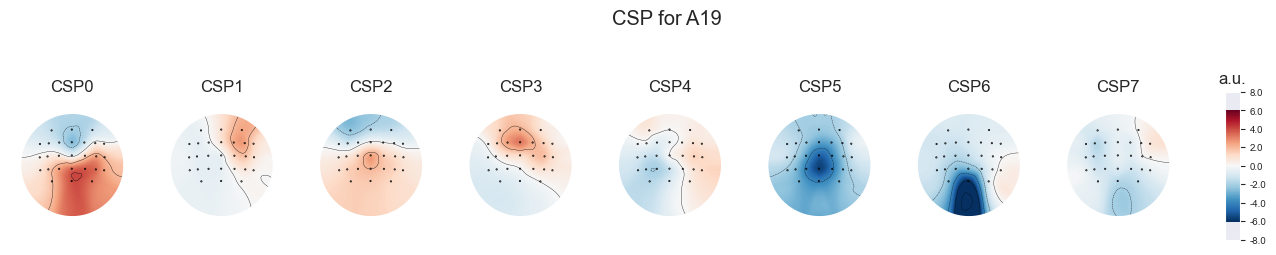

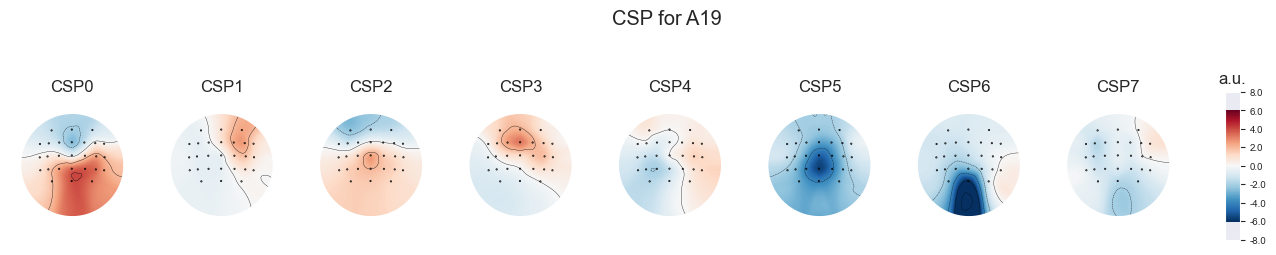

In [35]:
epoch = preprocess(dic_data_train["A10_1"], steps_preprocess)
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
epoch.set_montage(ten_twenty_montage)
csp.plot_patterns(epoch.info, title="CSP for %s " %subject)

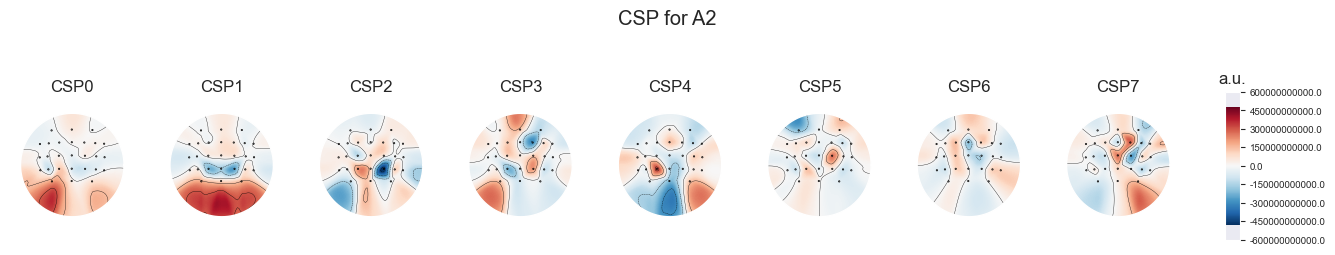

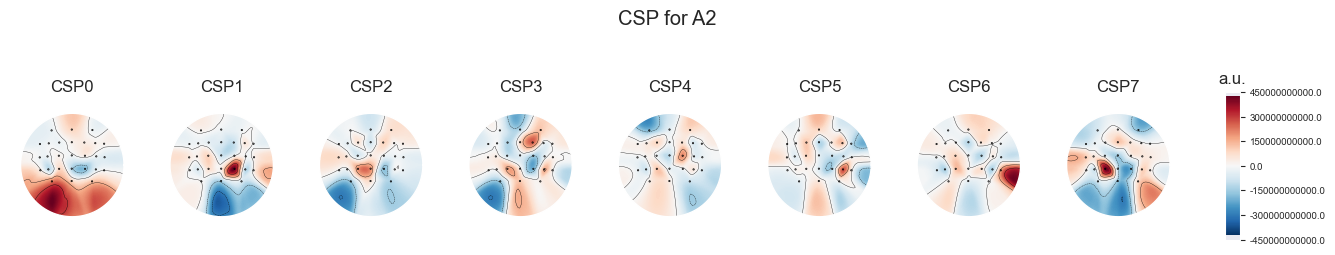

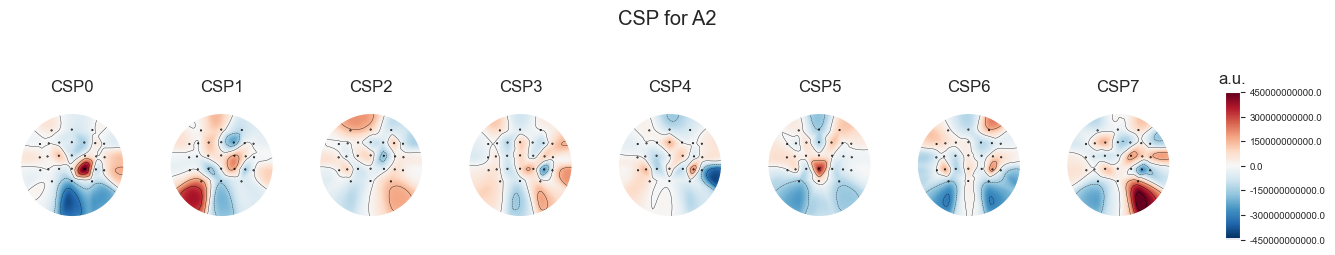

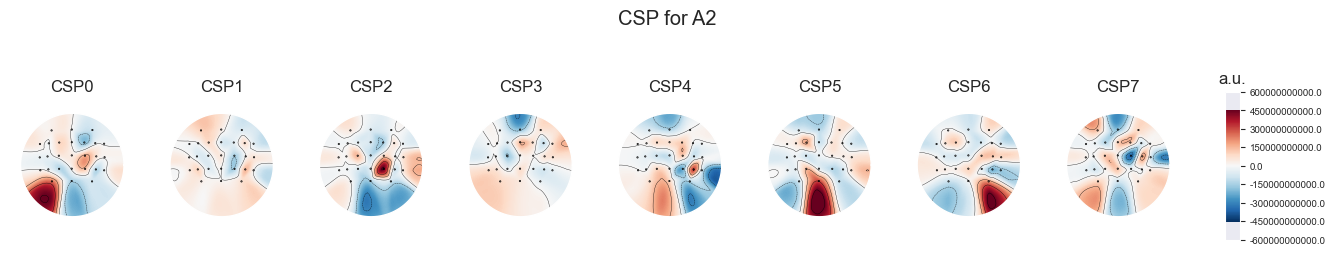

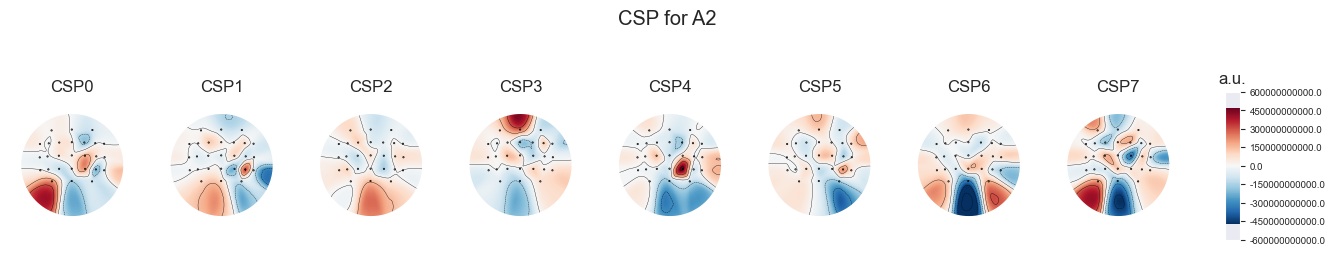

In [142]:
for shift in np.arange(-5, -2.8 ,0.5) :
    subject = "A2"
    train_key = [subject + "_1", subject + "_2"]

    steps_preprocess = {"filter": [8, 30],
                        "drop_channels": ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'],
                        "tmin": 0.25, "tmax": 5, "shift": shift, "overlap": 1 / 16, "lenght": 1}

    x_train, y_train = epoching(dic_data_train, train_key, steps_preprocess, key_events={"769": 0})
    csp = CSP(n_components=8)
    _ = csp.fit(x_train, y_train)
    epoch = preprocess(dic_data_train["A10_1"], steps_preprocess)
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
    epoch.set_montage(ten_twenty_montage)
    csp.plot_filters(epoch.info, title="CSP for %s " % subject)


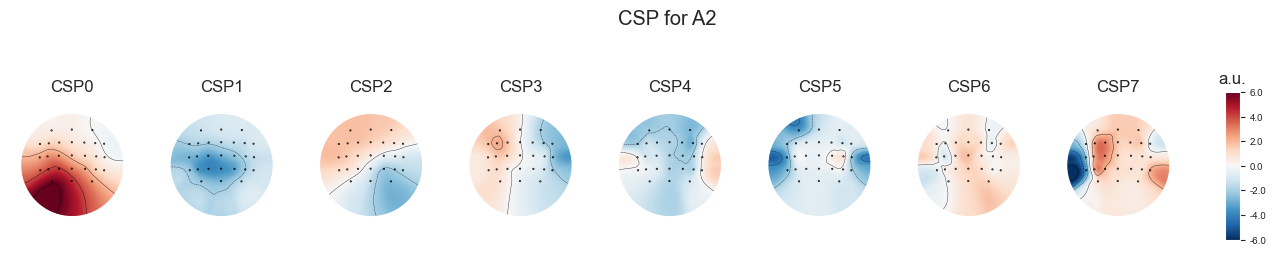

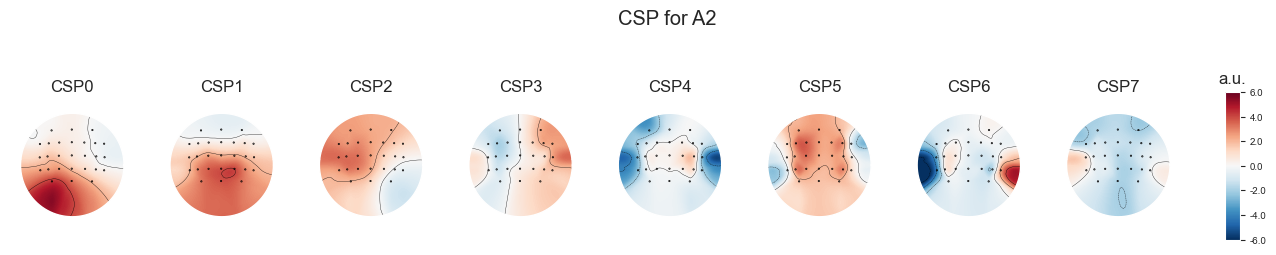

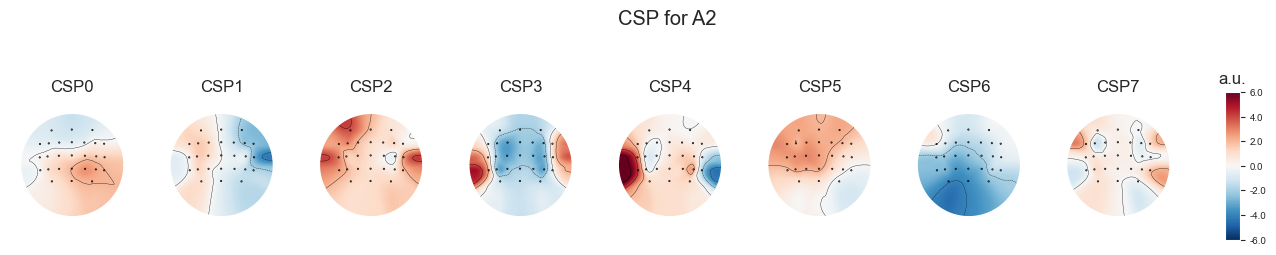

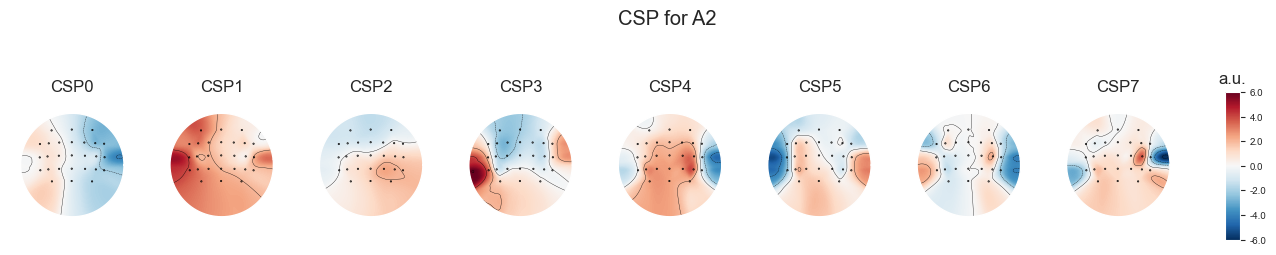

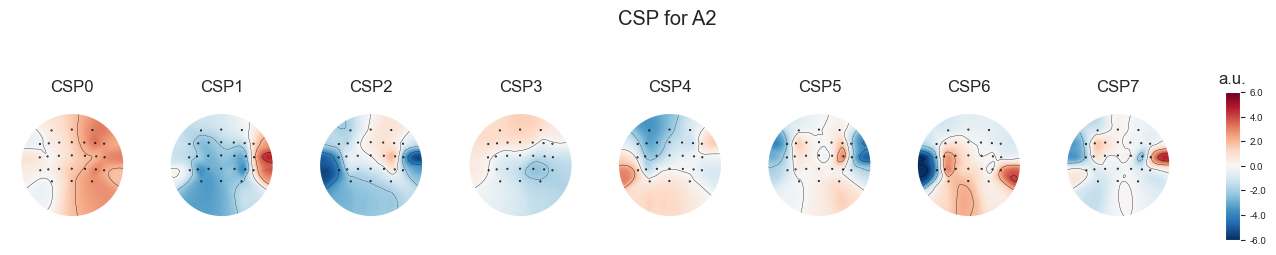

In [143]:
for shift in np.arange(-5, -2.8 ,0.5) :
    subject = "A2"
    train_key = [subject + "_1", subject + "_2"]

    steps_preprocess = {"filter": [8, 30],
                        "drop_channels": ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'],
                        "tmin": 0.25, "tmax": 5, "shift": shift, "overlap": 1 / 16, "lenght": 1}

    x_train, y_train = epoching(dic_data_train, train_key, steps_preprocess, key_events={"769": 0})
    csp = CSP(n_components=8)
    _ = csp.fit(x_train, y_train)
    epoch = preprocess(dic_data_train["A10_1"], steps_preprocess)
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
    epoch.set_montage(ten_twenty_montage)
    csp.plot_patterns(epoch.info, title="CSP for %s " % subject, vmax=6, vmin=-6)

In [37]:
csp.get_params(True)

{'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 8,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'}

In [36]:
subject = "A10"
train_key = [subject+"_1", subject+"_2"]

steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.25 , "tmax" : 5, "overlap" :1/16, "lenght": 1}

x_train, y_train = epoching(dic_data_train,train_key,steps_preprocess)

csp = CSP(n_components=6)
csp.fit(x_train, y_train)
epoch = preprocess(dic_data_train["A10_1"], steps_preprocess)
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
epoch.set_montage(ten_twenty_montage)
csp.plot_patterns(epoch.info)

KeyError: 'shift'

In [6]:
print('"dc')


a =1
B= a +1

"dc


Traceback (most recent call last):
  File "_pydevd_bundle\pydevd_cython_win32_39_64.pyx", line 1035, in _pydevd_bundle.pydevd_cython_win32_39_64.PyDBFrame.trace_dispatch
  File "C:\Program Files\JetBrains\DataSpell 2021.3\plugins\python-ce\helpers-pro\jupyter_debug\pydev_jupyter_plugin.py", line 144, in cmd_step_over
    if _is_inside_jupyter_cell(frame, pydb):
  File "C:\Program Files\JetBrains\DataSpell 2021.3\plugins\python-ce\helpers-pro\jupyter_debug\pydev_jupyter_plugin.py", line 209, in _is_inside_jupyter_cell
    if is_cell_filename(filename):
  File "C:\Program Files\JetBrains\DataSpell 2021.3\plugins\python-ce\helpers-pro\jupyter_debug\pydev_jupyter_plugin.py", line 220, in is_cell_filename
    ipython_shell = get_ipython()
NameError: name 'get_ipython' is not defined


2378

In [11]:
[0:6:2]

SyntaxError: invalid syntax (Temp/ipykernel_28556/3089502966.py, line 1)

In [14]:
inline_order = ["A1"  ,"A2" ,"A3" ,"A4" ,"A5" ,"A6" ,"A7" ,"A8" ,"A9" ,"A10" ,"A11" ,"A12" ,"A13" ,"A14" ,"A15" ,"A16" ,"A17" ,"A18" ,"A19" ,"A20" ,"A21" ,"A22" ,"A23" ,"A24" ,"A25" ,"A26" ,"A27" ,"A28" ,"A29" ,"A30" ,"A31" ,"A32" ,"A33" ,"A34" ,"A35" ,"A36" ,"A37" ,"A38" ,"A39" ,"A40" ,"A41" ,"A42" ,"A43" ,"A44" ,"A45" ,"A46" ,"A47" ,"A48" ,"A49" ,"A50" ,"A51" ,"A52" ,"A53" ,"A54" ,"A55" ,"A56" ,"A57" ,"A58" ,"A59" ,"A60" ,"B61" ,"B62" ,"B63" ,"B64" ,"B65" ,"B66" ,"B67" ,"B68" ,"B69" ,"B70" ,"B71" ,"B72" ,"B73" ,"B74" ,"B75" ,"B76" ,"B77" ,"B78" ,"B79" ,"B80" ,"B81" ,"C82" ,"C83" ,"C84" ,"C85" ,"C86" ,"C87"]

inline_order[1::2]

['A2',
 'A4',
 'A6',
 'A8',
 'A10',
 'A12',
 'A14',
 'A16',
 'A18',
 'A20',
 'A22',
 'A24',
 'A26',
 'A28',
 'A30',
 'A32',
 'A34',
 'A36',
 'A38',
 'A40',
 'A42',
 'A44',
 'A46',
 'A48',
 'A50',
 'A52',
 'A54',
 'A56',
 'A58',
 'A60',
 'B62',
 'B64',
 'B66',
 'B68',
 'B70',
 'B72',
 'B74',
 'B76',
 'B78',
 'B80',
 'C82',
 'C84',
 'C86']

In [52]:

pipelines = {}

#pipelines['8 csp+lda'] = make_pipeline(CSP(n_components=8), LDA())
pipelines['6 csp+lda'] = make_pipeline(CSP(n_components=6), LDA())

TypeError: unsupported operand type(s) for +: 'dict_keys' and 'str'

In [ ]:
session = participant_dir[0] #get the list of participant in the first exeperiment
steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.25 , "tmax" : 5, "overlap" :1/16, "lenght": 1,
                    "score" : "Tacc"}
accuracy_2  = test_pipeline_within_session(pipelines, session, steps_preprocess)

In [173]:
fusioned_accuracy = accuracy.join(accuracy_2, rsuffix = "_TAcc")

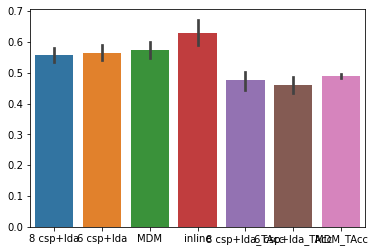

In [193]:
ax = sns.barplot(data= fusioned_accuracy)set_width

In [48]:
np.loadtxt("results/shift_rest_vs_MI_right.csv", delimiter=",")

ValueError: could not convert string to float: ''

In [51]:
right_classification = pd.read_csv("results/shift_rest_vs_MI_right.csv" ,index_col=0 )

In [52]:
classification = right_classification

In [140]:
classification.mean()

-5.5    0.716061
-5.0    0.718387
-4.5    0.701962
-4.0    0.688881
-3.5    0.681904
-3.0    0.648401
-2.5    0.633212
dtype: float64

<BarContainer object of 7 artists>

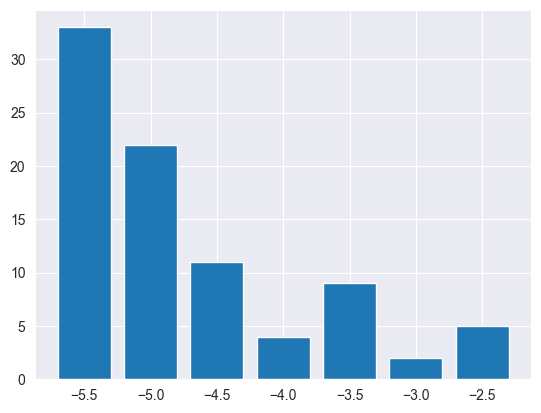

In [132]:
plt.bar(x=np.array(classification.idxmax(axis=1).value_counts().index, dtype="float") ,height =classification.idxmax(axis=1).value_counts(), width= 0.4)

<BarContainer object of 7 artists>

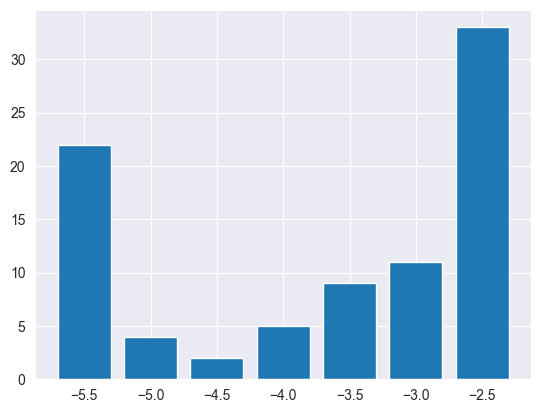

In [133]:
plt.bar(x=np.array(classification.idxmin(axis=1).value_counts().index, dtype="float") ,height =classification.idxmax(axis=1).value_counts(), width= 0.4)

<AxesSubplot:>

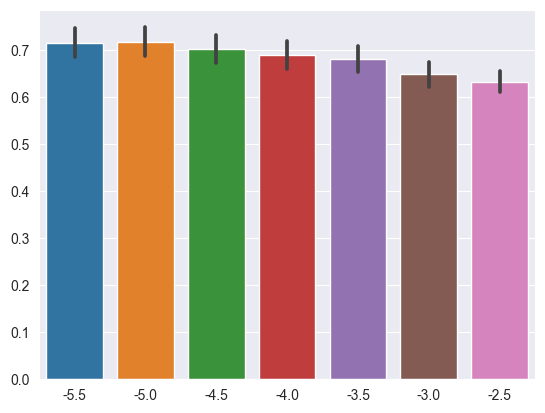

In [76]:
sns.barplot(data=classification)

In [107]:
diff = pd.DataFrame( index=classification.index, columns=["max", "min", "diff"])
diff["max"]= classification.idxmax(axis=1)
diff["min"] = classification.idxmin(axis=1)
diff

In [103]:
diff["A1"]=2
diff["A10"] =3

In [108]:
diff

max   min diff
A1   -5.0  -3.0  NaN
A10  -5.0  -2.5  NaN
A11  -5.5  -2.5  NaN
A12  -5.0  -2.5  NaN
A13  -5.5  -2.5  NaN
..    ...   ...  ...
C83  -5.5  -5.0  NaN
C84  -4.5  -2.5  NaN
C85  -5.5  -5.5  NaN
C86  -4.5  -5.5  NaN
C87  -4.5  -2.5  NaN

[86 rows x 3 columns]

In [134]:
classification[classification.idxmax(axis=1)]

-5.0     -5.0     -5.5     -5.0     -5.5     -2.5     -4.5     -4.0  \
A1   0.88125  0.88125  0.83750  0.88125  0.83750  0.80000  0.83750  0.78125   
A10  0.81875  0.81875  0.78750  0.81875  0.78750  0.70000  0.79375  0.79375   
A11  0.89375  0.89375  0.91875  0.89375  0.91875  0.74375  0.90000  0.85625   
A12  0.71250  0.71250  0.68750  0.71250  0.68750  0.55000  0.68125  0.64375   
A13  0.78750  0.78750  0.80625  0.78750  0.80625  0.70625  0.77500  0.78125   
..       ...      ...      ...      ...      ...      ...      ...      ...   
C83  0.50000  0.50000  0.51250  0.50000  0.51250  0.50000  0.50000  0.50000   
C84  0.83125  0.83125  0.83750  0.83125  0.83750  0.66250  0.84375  0.79375   
C85  0.50000  0.50000  0.50000  0.50000  0.50000  0.50000  0.50000  0.50000   
C86  0.74375  0.74375  0.71250  0.74375  0.71250  0.73750  0.76875  0.74375   
C87  0.77500  0.77500  0.80000  0.77500  0.80000  0.68750  0.83750  0.77500   

        -5.5     -5.5  ...     -5.0     -5.5     -5.0     -5.5     -4.5  \
A1   0.83750  0.83750  ...  0.88125  0.83750  0.88125  0.83750  0.83750   
A10  0.78750  0.78750  ...  0.81875  0.78750  0.81875  0.78750  0.79375   
A11  0.91875  0.91875  ...  0.89375  0.91875  0.89375  0.91875  0.90000   
A12  0.68750  0.68750  ...  0.71250  0.68750  0.71250  0.68750  0.68125   
A13  0.80625  0.80625  ...  0.78750  0.80625  0.78750  0.80625  0.77500   
..       ...      ...  ...      ...      ...      ...      ...      ...   
C83  0.51250  0.51250  ...  0.50000  0.51250  0.50000  0.51250  0.50000   
C84  0.83750  0.83750  ...  0.83125  0.83750  0.83125  0.83750  0.84375   
C85  0.50000  0.50000  ...  0.50000  0.50000  0.50000  0.50000  0.50000   
C86  0.71250  0.71250  ...  0.74375  0.71250  0.74375  0.71250  0.76875   
C87  0.80000  0.80000  ...  0.77500  0.80000  0.77500  0.80000  0.83750   

        -5.5     -4.5     -5.5     -4.5     -4.5  
A1   0.83750  0.83750  0.83750  0.83750  0.83750  
A10  0.78750  0.79375  0.78750  0.79375  0.79375  
A11  0.91875  0.90000  0.91875  0.90000  0.90000  
A12  0.68750  0.68125  0.68750  0.68125  0.68125  
A13  0.80625  0.77500  0.80625  0.77500  0.77500  
..       ...      ...      ...      ...      ...  
C83  0.51250  0.50000  0.51250  0.50000  0.50000  
C84  0.83750  0.84375  0.83750  0.84375  0.84375  
C85  0.50000  0.50000  0.50000  0.50000  0.50000  
C86  0.71250  0.76875  0.71250  0.76875  0.76875  
C87  0.80000  0.83750  0.80000  0.83750  0.83750  

[86 rows x 86 columns]

In [139]:
classification[:,'A1']

InvalidIndexError: (slice(None, None, None), 'A1')